In [1]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c bigmart-sales-data


403 - Forbidden


In [5]:
!unzip ./data/archive.zip -d  ./data


Archive:  ./data/archive.zip
  inflating: ./data/Test.csv         
  inflating: ./data/Train.csv        


# Project description

The data scientists at Big Mart have collected 2013 sales data for 1559 products across 10 stores in different cities. Also, certain attributes of each product and store have been defined. The aim is to build a predictive model and predict the sales of each product at a particular outlet.

## setting up the data and import libraries


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler

from sklearn.metrics import *


In [15]:
## data collection and Analysis

In [74]:
df=pd.read_csv('./data/Train.csv')

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## Observations and Insights

1. items identifier 
FD: Food
DR: Drinks
NC: Non-Consumable

In [18]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


array([[<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>],
       [<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
        <Axes: ylabel='Frequency'>]], dtype=object)

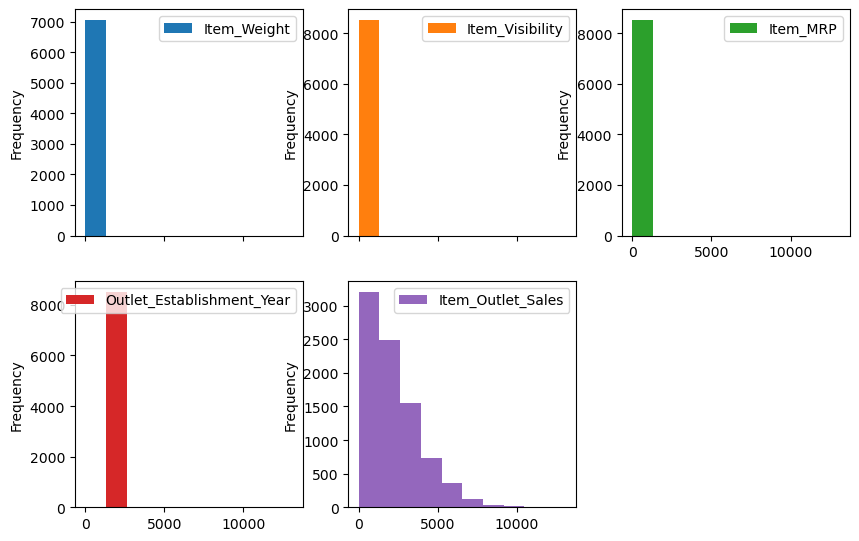

In [17]:
df.plot(kind='hist',subplots=True,layout=(3,3),figsize=(10,10))

# Data Processing Data Cleaning


categorical Feature:
* Item_Identifier
* Item_Fat_Content
* Item_Type
* Outlet_Identifier
* Outlet_Size
* Outlet_Location_Type
* Outlet_Type

Numerical Feature:
* Item_Weight
* Item_Visibility
* Item_MRP
* Outlet_Establishment_Year
* Item_Outlet_Sales

In [22]:
# missing values
df.isnull().sum()
# for weight and outlet size we will use mean and mode respectively


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [75]:
# fill missing values with scikit-learn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


item_weight_imputer= SimpleImputer(missing_values=np.nan, strategy='mean')
outlet_size_imputer= SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# define features

features=['Item_Weight','Outlet_Size']

# create an imputer object

imputer=ColumnTransformer([
    ('item_weight_imputer',item_weight_imputer,['Item_Weight']),
    ('outlet_size_imputer',outlet_size_imputer,['Outlet_Size'])
],remainder='passthrough')


# fit imputer to data

imputer.fit(df[features])

# transform data

df[features]=imputer.transform(df[features])

df.isnull().sum()





Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [40]:
df["Item_Weight"]=df["Item_Weight"].astype(int) # converting float to int

In [24]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.5,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.2,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# Analyse the data

In [41]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.330165,0.066132,140.992782,1997.831867,2181.288914
std,4.253895,0.051598,62.275067,8.371760,1706.499616
min,4.000000,0.000000,31.290000,1985.000000,33.290000
25%,9.000000,0.026989,93.826500,1987.000000,834.247400
50%,12.000000,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.000000,0.328391,266.888400,2009.000000,13086.964800


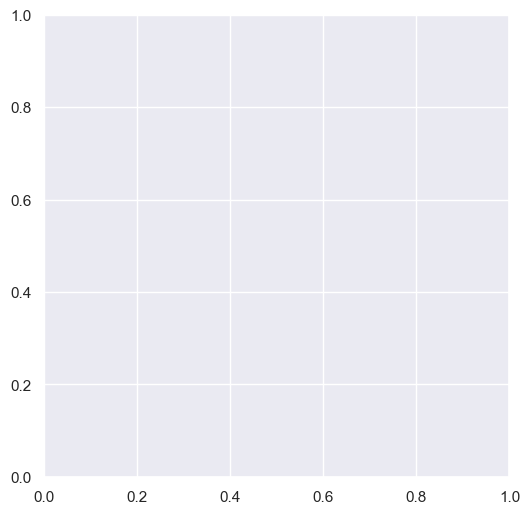

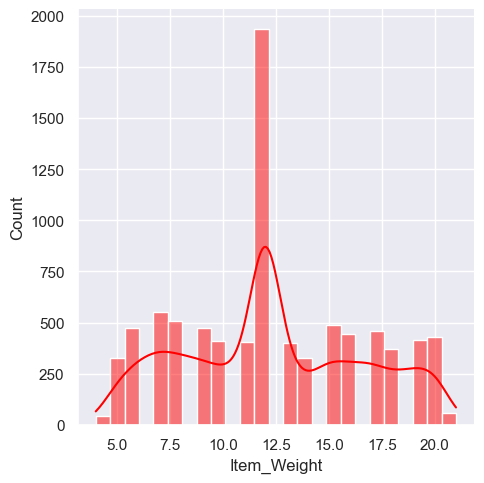

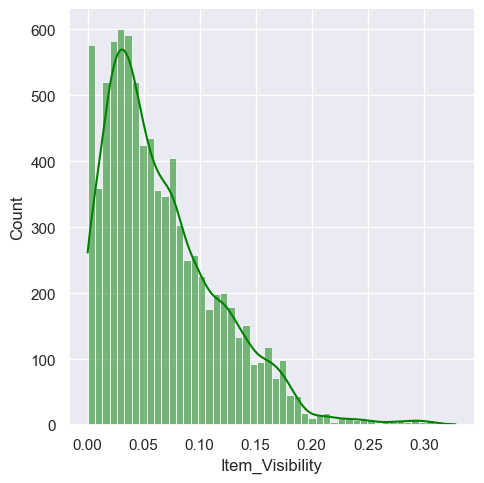

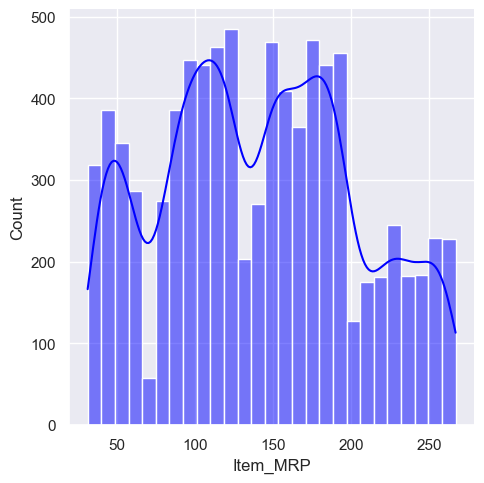

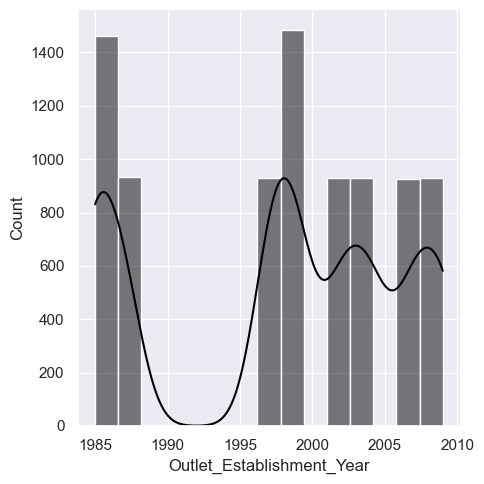

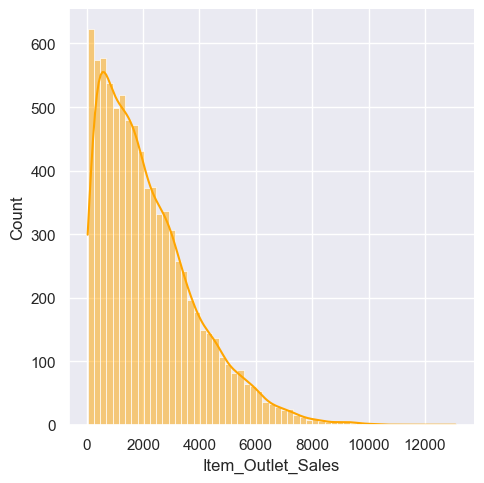

In [54]:
sns.set()

# plot all numerical features
fig,ax=plt.subplots(figsize=(6,6))

sns.displot(df['Item_Weight'],kde=True,color='red')

sns.displot(df['Item_Visibility'],kde=True,color='green')

sns.displot(df['Item_MRP'],kde=True,color='blue')

sns.displot(df['Outlet_Establishment_Year'],
                       kde=True, color='black')

sns.displot(df['Item_Outlet_Sales'],kde=True,color='orange')








<Axes: xlabel='Outlet_Establishment_Year', ylabel='count'>

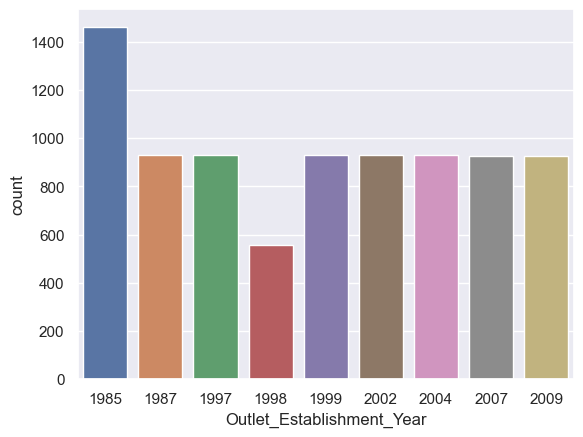

In [58]:
sns.countplot(x='Outlet_Establishment_Year',data=df)

<Axes: xlabel='Outlet_Type', ylabel='count'>

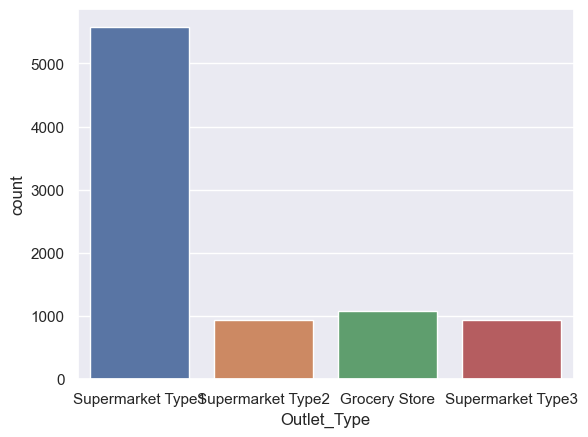

In [80]:
# from the above plot we can see that most of the outlets were established in 1985

sns.countplot(x='Outlet_Type',data=df)


<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

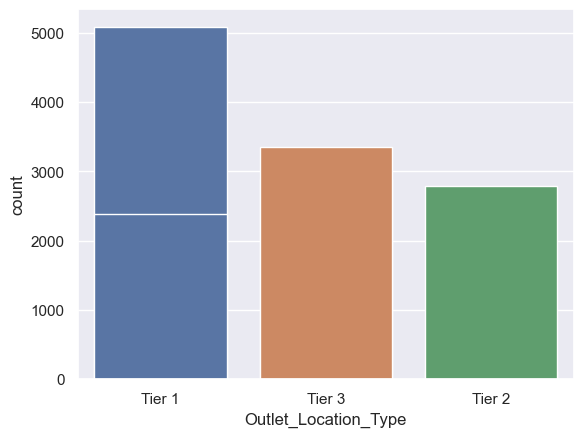

In [63]:

sns.countplot(x='Item_Fat_Content',data=df)

# from the above plot we can see that there are two types of fat content in the items

# Preprocessing the data

In [102]:
def pre_process_date(df):

    # for fat content we will replace LF and low fat with Low Fat and reg with Regular

    df['Item_Fat_Content']=df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'},inplace=True) 

    encoder=LabelEncoder()

    df['Item_Fat_Content']=encoder.fit_transform(df['Item_Fat_Content'])

    df['Item_Type']=encoder.fit_transform(df['Item_Type'])

    df['Outlet_Identifier']=encoder.fit_transform(df['Outlet_Identifier'])

    df['Outlet_Size']=encoder.fit_transform(df['Outlet_Size'])

    df['Outlet_Location_Type']=encoder.fit_transform(df['Outlet_Location_Type'])

    df['Outlet_Type']=encoder.fit_transform(df['Outlet_Type'])

    return df

encoder=LabelEncoder()
df['Item_Identifier']=encoder.fit_transform(df['Item_Identifier'])

In [82]:
df=pre_process_date(df)

df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,DRC01,5.92,0,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,FDN15,17.5,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,FDX07,19.2,0,0.000000,6,182.0950,0,1998,1,2,0,732.3800
4,NCD19,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


/var/folders/hn/5r0zs8c94dz3z1pnjkkmycfm0000gn/T/ipykernel_57916/177837602.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=df.corr()


<Axes: >

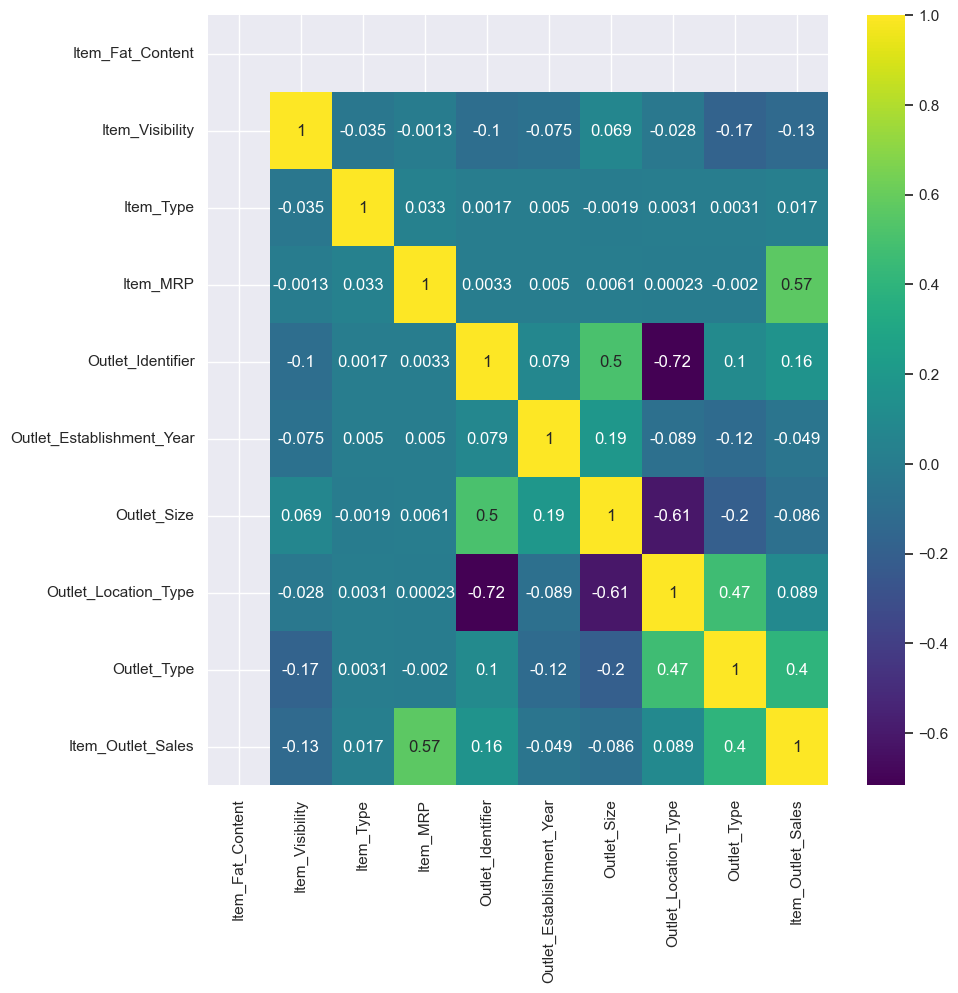

In [85]:
# correlation matrix

corr_matrix=df.corr()

corr_matrix['Item_Outlet_Sales'].sort_values(ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix,annot=True,cmap='viridis')

# from the above plot we can see that item mrp has the highest correlation with item outlet sales


In [103]:
# split data into train and test set

x=df.drop(['Item_Outlet_Sales'],axis=1) # features

y=df['Item_Outlet_Sales'] # target variable


x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)




In [104]:
def model_scores(models):
    model_scores={}
    for name,model in models.items():
        model.fit(x_train,y_train)
        model_scores[name]=model.score(x_test,y_test)
    return model_scores

In [105]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor


models={
    'Linear Regression':LinearRegression(),
    'Random Forest':RandomForestRegressor(),
}

model_scores(models)


{'Linear Regression': 0.5250176517603169, 'Random Forest': 0.5609280154762721}

In [106]:
def Evaluate(y_true,y_preds):

    """
    Performs evaluation comparison on y_true labels vs y_pred labels on a regression model
    """

    MAE=mean_absolute_error(y_true,y_preds)
    MSE=mean_squared_error(y_true,y_preds)
    RMSE=np.sqrt(MSE)
    R2=r2_score(y_true,y_preds)

    metric_dict={'MAE':MAE,
                 'MSE':MSE,
                 'RMSE':RMSE,
                 'R2':R2}

    print(f'MAE:{MAE}')
    print(f'MSE:{MSE}')
    print(f'RMSE:{RMSE}')
    print(f'R2:{R2}')

    return metric_dict



In [107]:
clf=RandomForestRegressor()

clf.fit(x_train,y_train)

y_preds=clf.predict(x_test)

Evaluate(y_test,y_preds)



MAE:759.2402034381232
MSE:1184714.2049634086
RMSE:1088.4457749302023
R2:0.5641180086879622


{'MAE': 759.2402034381232,
 'MSE': 1184714.2049634086,
 'RMSE': 1088.4457749302023,
 'R2': 0.5641180086879622}